## beautifulsoup & newspaper3k drawling

In [ ]:
from bs4 import BeautifulSoup
from newspaper import Article

#- 파싱할 뉴스 기사 주소입니다.
url = 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002881076'

#- 언어가 한국어이므로 language='ko'로 설정해줍니다.
article = Article(url, language='ko')
article.download()
article.parse()

In [ ]:
#- 기사 제목을 출력합니다.
print('기사 제목 :')
print(article.title)
print('')

#- 기사 내용을 출력합니다.
print('기사 내용 :')
print(article.text)

In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [ ]:
#. 한 페이지당 뉴스 기사가 20개임을 감안하여 총 40개의 url리스트 받아오기
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

url_list1 = make_urllist(2, 101, 20200804)
print('뉴스 기사의 개수: ',len(url_list))

In [ ]:
#. 5개만 출력해 보기
url_list[:5]

In [ ]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [ ]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

경제 카테고리(코드 101)의 40개의 URL 리스트로부터 데이터프레임을 생성

In [ ]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

## 3-8. 네이버 뉴스 기사 크롤링 (3) 데이터 수집 및 전처리
여러 카테고리에 뉴스들도 수집해보기 -> 특저 날짜의 사회, 생활/문화, IT/과학

In [ ]:
# 수집을 원하는 카테고리 코드를을 저장한 리스트를 만들어두기
code_list = [102, 103, 105]

code_list

In [ ]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [ ]:
df = make_total_data(1, code_list, 20200506)

In [ ]:
print('뉴스 기사의 개수: ',len(df))

In [ ]:
# n v a <- exclude all. or extract n
# 60개중 임의의 10개 샘플 선택하여 출력
df.sample(10)

## 대량크롤링


In [ ]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

## 아래 블럭만 실행하지 말기!!! 누적되서 망함

In [ ]:
# 크롤링한 뉴스 기사의 양이 많으므로 실수로 유실하지 않도록 csv 파일로 별도 저장

import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
###### csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
###### df.to_csv(csv_path, index=False)

###### if os.path.exists(csv_path):
######  print('{} File Saved!'.format(csv_path))

### 3-9. naver news article crawling (4) data preprocessing\
데이터를 가공/정제하여 모델의 훈련에 사용하기 좋은 숫자의 형태로 바꿔준다

In [2]:
#. 저장해둔 csv파일을 다시 읽어서 dataframe으로 저장하기 위한 코드
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [3]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

In [4]:
# data에 null값이 있진 않은지 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [5]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


데이터 탐색
---
각 카테고리별 샘플 분포 확인 -> matplotlib에 한글폰트 적용안될 수 있음 주의
[matplotlib 한글폰트 설정방법](https://followers.tistory.com/26)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44544 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44544 missing from current font.
  font.set_text(s, 0, flags=flags)


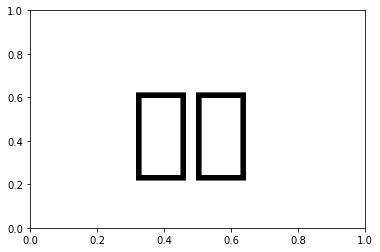

In [6]:
#. 한글 출력
import matplotlib.pyplot as plt
plt.text(0.3, 0.3, '한글', size=100)

from matplotlib import font_manager as fm
font_location='/home/aiffel/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524-ligature.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
plt.rc('font',family=font_name)

In [7]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc',
 '/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc',
 '/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc',
 '/usr/share/fonts/truetype/tlwg/TlwgMono-Oblique.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/home/aiffel/.local/share/fonts/D2Coding-Ver1.3.2-20180524-ligature.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypewriter-BoldOblique.ttf',
 '/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf',
 '/usr/share/fonts/truetype/tlwg/Umpush-BoldOblique.ttf',
 '/usr/share/fonts/opentype/firacode/FiraCode-Retina.otf',
 '/usr/share/fonts/truetype/tlwg/Umpush-LightOblique.ttf',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc',
 '/usr/share/fonts/truetype/kacst/KacstTitleL.ttf',
 '/usr/share/fonts/opentype/noto/

In [11]:
font_location='/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

<AxesSubplot:>

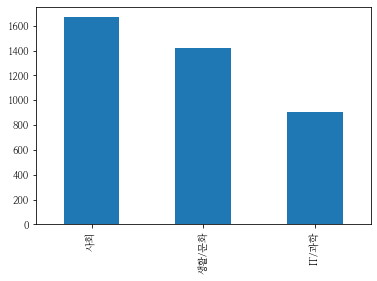

In [9]:
df['code'].value_counts().plot(kind = 'bar')

In [10]:
# 실 개수 확인
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


### 토큰화
자연어 처리 - 문자열은 특정 단위로 나누어지는데 이 특정 단위가 바로 토큰이다
토크나이징 - 문자열을 토큰으로 break down into pieces
[영어와 한국어의 토큰화의 차이](https://wikidocs.net/21698)   
-> 한국어 자연어처리의 경우에는 토큰화 과정을 주로 형태소 분석기를 사용해서 수행    
한국어의 경우 교착어라는 특성으로 인해 조사, 어미 등이 붙어있어 띄어쓰기 단위로
토큰화를 할 경우에는 같은 단어임에도 다른 단어로 인식될 수 있다.

In [14]:
# 형태소 패키지 라이브러리 Mecab
# Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나눠줌
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


자연어 처리: 토큰화 결과가 얼마나 정확한지에 다라 그 성능에 많은 영향을 받는다    
형태소 분석기의 결과가 머신러닝 결과의 성능에 큰 영향을 주기도 한다

### 불용어 제거(stopwords)
토큰화 전처리 필수과정 - 불필요한 토큰들을 제거하는 불용어 제거     


In [34]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', 'ㄴ','었','었다']

불용어 - 미리 짐작하여 한 번에 정의한는 것이 아니라 토큰화 과정을 거친 결과를 지속적으로 확인하면서 계속 추가하게 되는게 일반적이다

In [16]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [17]:
# 전체 데이터에 대해서 토큰화 및 불용어 제거를 수행한 뒤 첫 번째 샘플을 출력
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


### ML모델 적용을 위해 필요한 도구들 가져오기

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [19]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

In [20]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


기계는 텍스트보다 숫자를 더 잘 처리한다    
ML모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있다    
TF-IDF 방법 사용

### 각 뉴스 문서를 TF-IDF 벡터로 바꾼 뒤 나이브 베이즈 분류기를 학습

`fit_transform()` 함수는 fit, transform을 연이어 수행하는 함수로, `CountVectorizer.fit_transform()` 은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 준다
[사이킷런 참고자료](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [21]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [22]:
# 테스트 하기

# 텍스트 입력을 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수 만들기
# 이걸로 바로 txt -> 나이브 베이즈 분류기 입력으로 사용함으로써 용이한 테스트 가능

In [23]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [24]:
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [25]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [26]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [27]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.93      0.78      0.85       237
          사회       0.79      0.90      0.84       428
       생활/문화       0.81      0.76      0.79       334

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



# 3-11. 프로젝트 - 모델 성능 개선하기

## Step 1. 형태소 분석기 변경해 보기

In [29]:
# 형태소 패키지 라이브러리 Mecab
# Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나눠줌
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [30]:
# 불용어
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [31]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [ ]:
text_data=preprocessing(df['news'])
print(text_data[0])

### (1) Hannanum 분석기

In [35]:
print(stopwords)

['에', '는', '은', '을', '했', '에게', '있', '이', '의', '하', '한', '다', '과', '때문', '할', '수', '무단', '따른', '및', '금지', '전재', '경향신문', '기자', '는데', '가', '등', '들', '파이낸셜', '저작', '등', '뉴스', 'ㄴ', '었', '었다']


In [36]:
from konlpy.tag import Hannanum
tokenizer=Hannanum()
"""
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'
"""
print(tokenizer.morphs(kor_text))
#print(tokenizer_h.nouns(kor_text))
# stopwords에 ㄴ, ㅇ 을 추가해야 할까??


['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포됐다피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었다']


In [37]:
text_data=preprocessing(df['news'])
print(text_data[0])

파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기 자 파 아 주 시는 일 관내 취약계층 만가구 대 어 어 정부 긴급재난지원금 입금 완료했다파주시민 받 긴급재난지원금 일 이상 가구 기준 으로 만원 받 게 되 며 일 가구 만원 일 가구 만원 일 가구 만원이다정부 발표 긴급재난지원금 파주시민 지급 금액 다르 이유 국비지방비 부담 비율 때문이다파주시 이미 모든 시민 경기도파주시 재난기본소득인당 각 만원 지급 하고 어 시민 국비 지원금 만 지급 며 일 가구 기준 으로 총 지원 금액 파주시 재난기본소득 만원 경기 도 재난기본소득 만원 정부 긴급재난지원금 만원 총 만원 받 게 된다취약계층 아니 시민 오 월일 부터 소 지 하고 신용체크카드사 홈페이지 에서 긴급재난지원금 지원 신청 ㄹ 세대주 가족 지원금 일괄 신청 어야 한다한편 파 아 주 시는 일 김정기 부시장 단장 으로 긴급재난지원금 추진 태스크포스 를 구성해 긴급재난지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 저작권자 파이낸셜뉴스 전재재배포


### 추가할 stopword : ㄹ, ㄴ다, 며, 게

### hannanum ML모델 적용하여 평가하기

In [38]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [66]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']

['생활/문화']

['IT/과학']

['IT/과학']


In [44]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.94      0.70      0.80       237
          사회       0.78      0.89      0.83       428
       생활/문화       0.78      0.77      0.78       334

    accuracy                           0.81       999
   macro avg       0.83      0.79      0.80       999
weighted avg       0.82      0.81      0.81       999



### (2) Kkma 분석기 

In [45]:
from konlpy.tag import Kkma
tokenizer=Kkma()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

# stopwords 었, ㄴ, 는, 다, 었다, 을 추가!?

['밤', '에', '귀가', '하', '더', 'ㄴ', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속', '되', '었', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '하', '어', '수사', '하', '고', '있', '다고', '일', '밝히', '었', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서', '부터', '따라가', '폭행을', '시도', '하', '려', '다그', '아', '도망가', 'ㄴ', '혐의', '를', '받', '는', '다', '피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '었', '으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '더', 'ㄴ', '경찰', '에', '체포', '되', '었', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '하', 'ㄴ', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었', '다']


In [46]:
text_data=preprocessing(df['news'])
print(text_data[0])

파주 시청 사진 제공 파주시 파주 시청 사진 제공 파주시 파주 강 근주 파주시 일 관내 취약 계층 만 가구 대하 어 정부 긴급 재난 지원금 입금 완료 파주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만원 받 게 되 며 가구 만원 인 가구 만원 인 가구 만원 정부 발표 긴급 재난 지원금 파주시 민 지급 금액 다르 이유 국비 지방비 부담 비율 파주시 이미 모든 시민 경기도 파주시 재난 기본 소득 당 각 만원 지급 고 어 시민 국비 지원금 만 지급 며 가구 기준 으로 총 지원 금액 파주시 재난 기본 소득 만원 경기도 재난 기본 소득 만원 정부 긴급 재난 지원금 만원 총 만원 받 게 되 ㄴ다 취약 계층 아니 시민 오 월일 부터 소지 고 신용 체크 카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 ㄹ 세대주 가족 지원금 일괄 신청 어야 ㄴ다 한편 파주시 일 김 정기 부시장 단장 으로 긴급 재난 지원금 추진 태스크 포스 를 구성 어 긴급 재난 지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 저작권자 재 배포


### Kkma 형태소 분석기 ML 모델 적용하여 평가하기

In [47]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [48]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']

['생활/문화']

['IT/과학']

['IT/과학']


In [49]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.93      0.76      0.84       237
          사회       0.79      0.89      0.84       428
       생활/문화       0.80      0.78      0.79       334

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### (3) Komoran 형태소 분석기

In [50]:
from konlpy.tag import Komoran
tokenizer=Komoran()
# stopwords
print(stopwords)
# 형태소 분석
print(tokenizer.morphs(kor_text))

['에', '는', '은', '을', '했', '에게', '있', '이', '의', '하', '한', '다', '과', '때문', '할', '수', '무단', '따른', '및', '금지', '전재', '경향신문', '기자', '는데', '가', '등', '들', '파이낸셜', '저작', '등', '뉴스', 'ㄴ', '었', '었다']
['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속', '되', '었', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '하', '아', '수사', '하', '고', '있', '다고', '일', '밝히', '었', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '아', '폭행', '을', '시도', '하', '려다가', '도망가', 'ㄴ', '혐의', '를', '받', '는다', '피하', '아', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '았', '으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '되', '었', '다', '피하', '아', '여성', '은', '이', '과정', '에서', '경미', '하', 'ㄴ', '부상', '을', '입', '은', '것', '으로', '전하', '아', '지', '었', '다']


In [51]:
# 전처리
text_data=preprocessing(df['news'])
print(text_data[0])

파주 시청 사진 제공 파주시 파주 시청 사진 제공 파주시 파주 파이낸셜뉴스 강 근 주 파주시 일 관내 취약 계층 만 가구 대하 아 정부 긴급 재난 지원금 입금 완료 았 파주시 민이 받 긴급 재난 지원금 인 이상 가구 기준 으로 만원 받 게 되 며 인 가구 만원 인 가구 만원 인 가구 만원 이다 정부 발표 긴급 재난 지원금 파주시 민 지급 금액 다른 이유 국비 지방비 부담 비율 이다 파주시 이미 모든 시민 경기도 파주시 재난 기본소득 인당 각 만원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만원 경기도 재난 기본소득 만원 정부 긴급 재난 지원금 만원 총 만원 받 게 되 취약 계층 아니 시민 오 월 일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 ㄹ 세대주 가족 지원금 일괄 신청 아야 한편 파주시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태스크포스를 구성 아 긴급 재난 지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 저작권 자 파이낸셜뉴스 재 배포


### Komoran 형태소 분석기 ML 모델 적용하여 평가하기

In [52]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [53]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']

['생활/문화']

['IT/과학']

['IT/과학']


In [54]:
# evaluation
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.92      0.77      0.84       237
          사회       0.79      0.89      0.84       428
       생활/문화       0.80      0.77      0.78       334

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### (4) Okt 형태소 분석기

In [55]:
from konlpy.tag import Okt
tokenizer=Okt()
# stopwords
print(stopwords)
# 형태소 분석
print(tokenizer.morphs(kor_text))

['에', '는', '은', '을', '했', '에게', '있', '이', '의', '하', '한', '다', '과', '때문', '할', '수', '무단', '따른', '및', '금지', '전재', '경향신문', '기자', '는데', '가', '등', '들', '파이낸셜', '저작', '등', '뉴스', 'ㄴ', '었', '었다']
['밤', '에', '귀가', '하던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐다', '서울', '제', '주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하고', '있다고', '일', '밝혔다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하려다가', '도망간', '혐의', '를', '받는다', '피해', '여성', '이', '저항', '하자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받고', '주변', '을', '수색', '하던', '경찰', '에', '체포', '됐다', '피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입은', '것', '으로', '전해졌다']


In [56]:
# 전처리
text_data=preprocessing(df['news'])
print(text_data[0])

파주 시청 사진 제공 파주시 파주 시청 사진 제공 파주시 파주 파이낸셜뉴스 강 근 주 파주시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지 원금 입금 완료 했다 파주시민 받는 긴급 재난 지원 금은 인 이상 가구 기준 으로 만원 받게 되며 인 가구 만원 인 가구 만원 인 가구 만원 이다 정부 발표 긴급 재난 지 원금 파주시민 지급 금액 다른 이유 국비 지 방비 부담 비율 이다 파주시 이미 모든 시민 경기도 파주시 재난 기본소득 인 당 각 만원 지급 하고 있어 시민 국비 지 원금 만 지급 하며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만원 경기도 재난 기본소득 만원 정부 긴급 재난 지 원금 만원 총 만원 받게 된다 취약 계층 아닌 시민 오는 월일 부터 소지 하고 있는 신용 체크카드 사 홈페이지 에서 긴급 재난 지 원금 지원 신청 있다 세대주 가족 지 원금 일괄 신청 해야 한다 한편 파주시 일 김정기 부시장 단장 으로 하는 긴급 재난 지 원금 추진 태스크포스 를 구성 해 긴급 재난 지 원금 원활하게 지급 될 있도록 지원 저작권 자 파이낸셜뉴스 전 재재 배포


### Komoran 형태소 분석기 ML 모델 적용하여 평가하기

In [57]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [58]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']

['생활/문화']

['IT/과학']

['IT/과학']


In [59]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.94      0.75      0.83       237
          사회       0.77      0.90      0.83       428
       생활/문화       0.81      0.75      0.78       334

    accuracy                           0.81       999
   macro avg       0.84      0.80      0.81       999
weighted avg       0.82      0.81      0.81       999



## Step1 분석기별 장단점, 처리속도, 성능
- 대략적인 장단점
    - Kkma: 제일 느리다는 단점이 있다
- 처리속도: Mecab <<<<< Kkma
- 성능(f1 score): 